In [1]:
# Install packages
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import collections
import time

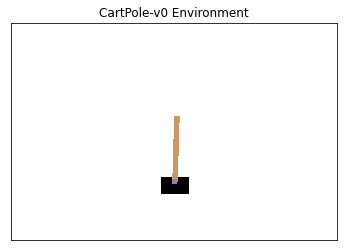

In [61]:
# Demonstration
env = gym.envs.make("CartPole-v1")


def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Speify the number of simulation steps
num_steps = 2

# Show several steps
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v0 Environment')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

In [2]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [63]:
def random_search(env, episodes, 
                  title='Random Strategy'):
    """ Random search strategy implementation."""
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            #print(env.step(action))
            next_state, reward, done, _ = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
        plot_res(final,title)
    return final

In [45]:
# Get random search results
env = gym.envs.make("CartPole-v1")
random_s = random_search(env, 50)

KeyboardInterrupt: 

In [3]:
class Network(torch.nn.Module):
    ''' Deep Q Neural Network class. '''
    def __init__(self, input_dim, output_dim, hidden_dim=50):
        super(Network, self).__init__()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(input_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, output_dim)
                )
        
    def forward(self, state):
        """ Compute Q values for all actions using the DQL. """
        #with torch.no_grad():
        return self.model(torch.Tensor(state))

In [4]:
class Agent():
    def __init__(self, lr=0.05):
        self.env = gym.envs.make("CartPole-v1")
        self.dqn = DQN(lr)
        self.gamma = 0.9
        self.epsilon = 0.3
        self.eps_decay=0.99
        
            
    def q_learning(self, episodes, title = 'DQL', verbose=True):
        """Deep Q Learning algorithm using the DQN. """
        final = []
    
        buffer = ReplayBuffer()
        episode_i=0
        sum_total_replay_time=0
        for episode in range(episodes):
            episode_i+=1
            #if double and not soft:
            #    # Update target network every n_update steps
            #    if episode % n_update == 0:
            #        self.target_update()
            #if double and soft:
            #    self.target_update()
            
            # Reset state
            state = self.env.reset()
            done = False
            total = 0
            
            while not done:
                # Implement greedy search policy to explore the state space
                action = self.get_epsilon_greedy_action(state)
                # Take action and add reward to total
                next_state, reward, done, _ = self.env.step(action)
                
                # Update total and memory
                total += reward
                transition = (state, action, next_state, int(reward), done)
                buffer.buffer_append(transition)
                batch = buffer.get_batch()
                self.dqn.train_q_network(batch, done, self.gamma)
    
                state = next_state
            
            # Update epsilon
            self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
            final.append(total)
            plot_res(final, title)
            
            if verbose:
                print("episode: {}, total reward: {}".format(episode_i, total))
                #if replay:
                #    print("Average replay time:", sum_total_replay_time/episode_i)
            
        return final
    
    def get_epsilon_greedy_action(self, state):
        if random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            q_values = self.dqn.q_network.forward(state)
            action = torch.argmax(q_values).item()
        return action

In [5]:
class ReplayBuffer():
    def __init__(self, maxlength = 10000):
        self.batch_size = 20
        self.maxlength = maxlength
        self.buffer = collections.deque(maxlen=maxlength)
    
    def buffer_append(self,transition):#, weight):
        if len(self.buffer) == self.maxlength:
            self.buffer.popleft()
            #self.w.popleft()
        self.buffer.append(transition)
        #self.w.append(weight)
        
    def get_batch(self):
        if len(self.buffer) >= self.batch_size:
            #indices = [len(self.buffer)-1]
            indices = np.random.choice(len(self.buffer), self.batch_size, replace=False)
        else:
            indices = range(len(self.buffer))
        states, actions, next_states, rewards, dones = zip(*[self.buffer[idx] for idx in indices])
        return (np.array(states,dtype=np.float32), np.array(actions), np.array(next_states,dtype=np.float32), np.array(rewards), np.array(dones), indices)
        

In [6]:
class DQN():
    def __init__(self, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.q_network = Network(4,2)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr)
        self.double=False 
        self.n_update=10
        self.soft=False
            
            
    def train_q_network(self, batch, done, gamma):
        """Update the weights of the network given a training sample. """
        states = batch[0]
        actions = batch[1]
        next_states = batch[2]
        rewards = batch[3]
        dones = batch[4]
        
        done_indices = np.where(dones)[0]
        not_done_indices = np.where(dones==False)[0]
        
        q_values = self.q_network.forward(states).detach().numpy()
        q_values[done_indices, actions[done_indices]] = rewards[dones]
        q_values_next = self.q_network.forward(next_states[dones == False])
        q_values[not_done_indices, actions[not_done_indices]] = rewards[not_done_indices] + gamma * torch.max(q_values_next,1)[0].detach().numpy()
        
        loss = self.criterion(self.q_network.forward(states), Variable(torch.Tensor(q_values)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    

In [7]:
cart_pole = Agent(lr=0.001)
cart_pole.q_learning(episodes = 150)

KeyboardInterrupt: 